# Based on general purpose language model, train a 'DESCRIPTION' classifier

Instead of building from a MIMIC trained language model, use the general purpose ULMFit Wiki trained model

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split
import glob
import gc

Setup filenames and paths

In [2]:
# pandas doesn't understand ~, so provide full path
base_path = Path.home() / 'mimic'

# files used during processing - all aggregated here
admissions_file = base_path/'ADMISSIONS.csv'
notes_file = base_path/'NOTEEVENTS.csv'

class_file = 'wiki_cl_data.pickle'
notes_pickle_file = base_path/'noteevents.pickle'
lm_file = 'cl_lm.pickle' # actual file is at base_path/lm_file but due to fastai function, have to pass file name separately
init_model_file = base_path/'wiki_cl_head'
cycles_file = base_path/'wiki_cl_num_iterations.pickle'
enc_file = 'wiki_cl_enc'
freeze_two = base_path/'wiki_cl_freeze_two'
freeze_three = base_path/'wiki_cl_freeze_three'
descr_ft_file = 'wiki_cl_fine_tuned_'

training_history_file = 'wiki_cl_history'

Setup parameters for models

In [3]:
# original data set too large to work with in reasonable time due to limted GPU resources
pct_data_sample = 0.1
# how much to hold out for validation
valid_pct = 0.2
# for repeatability set seed; different seed than used with language model
seed = 1776
lm_seed = 42
# changing batch size affects learning rate
bs=96

In [4]:
# if this doesn't free memory, can restart Python kernel.
# if that still doesn't work, try OS items mentioned here: https://docs.fast.ai/dev/gpu.html
def release_mem():
    gc.collect()
    torch.cuda.empty_cache()
release_mem()

In [5]:
orig_df = pd.DataFrame()
if os.path.isfile(notes_pickle_file):
    print('Loading noteevent pickle file')
    orig_df = pd.read_pickle(notes_pickle_file)
    print(orig_df.shape)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(notes_file, low_memory=False, memory_map=True)
    orig_df.to_pickle(notes_pickle_file)

Loading noteevent pickle file
(2083180, 11)


In [6]:
df = orig_df.sample(frac=pct_data_sample, random_state=seed)

In [7]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1452901,1454539,14755,151669.0,2125-02-13,2125-02-13 05:37:00,2125-02-13 05:40:00,Nursing/other,Report,19585.0,NaN,Respiratory Care:\nPatient on PSV overnight of...
462929,466766,46041,176979.0,2160-06-02,2160-06-02 02:43:00,2160-06-02 02:57:32,Nursing,Nursing Progress Note,18654.0,NaN,"Shock, cardiogenic\n Assessment:\n Hemodyn..."
227661,237449,81883,118744.0,2143-10-28,NaN,NaN,ECG,Report,NaN,NaN,Compared to tracing #1 the patient's rate has ...
597361,603087,50450,147724.0,2191-09-20,2191-09-20 23:48:00,2191-09-20 23:48:27,Physician,Physician Attending Admission Note - MICU,16383.0,NaN,Chief Complaint: GI Bleed-melena and hemateme...
973311,962711,7287,108868.0,2152-06-02,2152-06-02 23:18:00,NaN,Radiology,PELVIS PORTABLE,NaN,NaN,[**2152-6-2**] 11:18 PM\n PELVIS PORTABLE ...


In [8]:
print('Unique Categories:', len(df.CATEGORY.unique()))
print('Unique Descriptions:', len(df.DESCRIPTION.unique()))

Unique Categories: 15
Unique Descriptions: 1708


In [9]:
df.DESCRIPTION.value_counts()

Report                                     113589
Nursing Progress Note                       19169
CHEST (PORTABLE AP)                         17102
Physician Resident Progress Note             6311
CHEST (PA & LAT)                             4463
                                            ...  
LP WRIST, AP & LAT VIEWS LEFT PORT              1
L US MAJOR JOINT ASP./INJ. LEFT                 1
US LOWER EXTREMITY, SOFT TISSUE                 1
admit/cpr note                                  1
PERC TRANHEP PORTOGRAPHY WITH PRESSURES         1
Name: DESCRIPTION, Length: 1708, dtype: int64

In [10]:
# quite an imbalance between various DESCRIPTIONS
s = df.DESCRIPTION.value_counts()
len(s[s == 1])

695

### Create language model without fine-tuning

Normally you would use transfer learning to adjust the language model to the new data.

In this case, I just want to test how the classifier would work without fine-tuning the language model. This is taking the WT-103 pretrained weights and updating the vocabulary to match MIMIC with no new training.

In [11]:
%%time

tmpfile = base_path/lm_file

if os.path.isfile(tmpfile):
    print('loading existing language model')
    lm = load_data(base_path, lm_file, bs=bs)
else:
    print('creating new language model')
    lm_df = orig_df.sample(frac=pct_data_sample, random_state=lm_seed)
    lm = (TextList.from_df(lm_df, base_path, cols='TEXT')
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=lm_seed)
               #We randomly split and keep 10% for validation
               .label_for_lm()
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    lm.save(tmpfile)
    print('completed creating new language model')

loading existing language model
CPU times: user 2.98 s, sys: 1.55 s, total: 4.53 s
Wall time: 33.1 s


In [12]:
learn = language_model_learner(lm, AWD_LSTM, drop_mult=0.3)
learn.save_encoder(enc_file)

#### This is a very CPU and RAM intensive process - no GPU involved

Also, since there are a wide range of descriptions, not all descriptions present in the test set are in the validation set, so cannot learn all of them.

In [13]:
filename = base_path/class_file
if os.path.isfile(filename):
    data_cl = load_data(base_path, class_file, bs=bs)
    print('loaded existing data bunch')
else:
    print('creating new data bunch')
    data_cl = (TextList.from_df(df, base_path, cols='TEXT', vocab=lm.vocab)
               #df has several columns; actual text is in column TEXT
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed)
               #We randomly split and keep 20% for validation, set see for repeatability
               .label_from_df(cols='DESCRIPTION')
               #building classifier to automatically determine DESCRIPTION
               .databunch(bs=bs))
    data_cl.save(filename)
    print('created new data bunch')

/data/anaconda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
critical care progress note, P US SIMPLE/SING ABSC/CYST DRAIN/INCISION PORT, RO WRIST(3 + VIEWS) RIGHT IN O.R., Speech consult, Physician Attending/ Resident Admission Note - MIC...
  if getattr(ds, 'warn', False): warn(ds.warn)


created new data bunch


In [14]:
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(average='weighted', beta=1)])
learn.load_encoder(enc_file)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


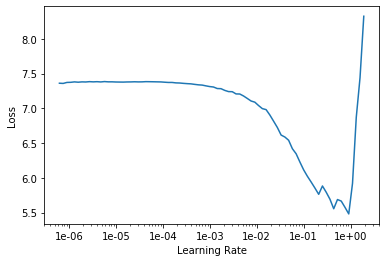

In [16]:
learn.recorder.plot()

Change learning rate based on results from the above plot

In [17]:
if os.path.isfile(str(init_model_file) + '.pth'):
    learn.load(init_model_file)
    print('loaded initial learner')
else:
    print('Training new initial learner')
    learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new learner')
    learn.save(init_model_file)
    print('Finished generating new learner')

Training new initial learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.870093,0.619279,0.870319,0.847263,19:45


Saving new learner
Finished generating new learner


Now need to fine tune

    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.522397	1.165042	0.925112	0.909121	26:11


In [18]:
if os.path.isfile(str(freeze_two) + '.pth'):
    learn.load(freeze_two)
    print('loaded freeze_two learner')
else:
    print('Training new freeze_two learner')
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7),
                        callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_two learner')
    learn.save(freeze_two)
    print('Finished generating new freeze_two learner')

Training new freeze_two learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.461766,10.529895,0.926606,0.911102,21:49


Saving new freeze_two learner
Finished generating new freeze_two learner


    epoch	train_loss	valid_loss	accuracy	f_beta	time
        0	0.343909	36.842651	0.940099	0.927041	38:25

In [19]:
if os.path.isfile(str(freeze_three) + '.pth'):
    learn.load(freeze_three)
    print('loaded freeze_three learner')
else:
    print('Training new freeze_three learner')
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7),
                       callbacks=[
                           callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                       ])
    print('Saving new freeze_three learner')
    learn.save(freeze_three)
    print('Finished generating new freeze_three learner')

Training new freeze_three learner


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.374493,36.742886,0.941232,0.928033,33:39


Saving new freeze_three learner
Finished generating new freeze_three learner


In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


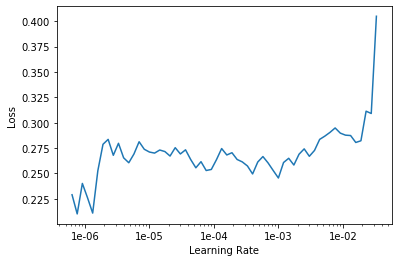

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
release_mem()

In [23]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0

In [24]:
num_cycles = 4

file = descr_ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = descr_ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.375308,30.573524,0.945352,0.933863,44:23
1,0.264289,0.245355,0.953569,0.942494,46:10
2,0.211814,0.227228,0.956315,0.946904,44:52
3,0.234732,0.302814,0.959183,0.950399,36:28


In [25]:
if os.path.isfile(cycles_file):
    with open(cycles_file, 'rb') as f:
        prev_cycles = pickle.load(f)
    print('This model has been trained for', prev_cycles, 'epochs already')  
else:
    prev_cycles = 0

This model has been trained for 4 epochs already


In [26]:
num_cycles = 3

file = descr_ft_file + str(prev_cycles)
learner_file = base_path/file
callback_save_file = str(learner_file) + '_auto'

learn.fit_one_cycle(num_cycles, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7),
                    callbacks=[
                        callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name=callback_save_file),
                        # CSVLogger only logs when num_cycles are complete
                        callbacks.CSVLogger(learn, filename=training_history_file, append=True)
                    ])
file = descr_ft_file + str(prev_cycles + num_cycles)
learner_file = base_path/file
learn.save(learner_file)

with open(cycles_file, 'wb') as f:
    pickle.dump(num_cycles + prev_cycles, f)
release_mem()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.279639,0.305670,0.956629,0.946835,41:51
1,0.220214,0.189874,0.960291,0.952471,34:44
2,0.194017,0.181148,0.963327,0.955776,34:45
